In [1]:
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
import numpy as np
import sklearn

In [2]:
from confidenceinterval import classification_report_with_ci
from confidenceinterval.bootstrap import bootstrap_ci


# Evaluate Multi-Class


## Load and combine multiple files with predictions

In [3]:
# each of the sub-lists will determine the reading of the relevant files
prompt_ids_to_eval = [["P1"], ["P2"], ["P3_1"], ["P3_2", "P3_3", "P3_4"], ["P4_1", "P4_2"], ["P5", "P6", "P7"], ["P9", "P9_1"], ["P10", "P11"], ["P11_1", "P11_2", "P11_3"], ["P11_4", "P11_5"], ["P12"], ["P12_1", "P12_2"]]

model = "gpt-3.5-turbo" #"gpt-3.5-turbo" "gpt-4-turbo-preview"
#data_type = "enriched_kw"
#data_type = "enriched"
data_type = ""

In [4]:
# Define a function to process each sublist
def process_prompt_ids(prompt_ids):
    # Create the list of prediction columns based on the prompt IDs
    prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids]
    # Specify the basic columns to include in the DataFrame
    basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
    # Combine basic columns with the dynamically generated prediction columns
    columns_to_read = basic_columns + prediction_columns
    # Read the CSV file
    df = pd.read_csv(f"predictions/{model}_{data_type}test_outputs_{'_'.join(prompt_ids)}.csv")[columns_to_read]
    #df = pd.read_csv(f"predictions/{model}_{data_type}_test_outputs_{'_'.join(prompt_ids)}.csv")[columns_to_read]
    return df, prediction_columns
    
# Initialize an empty set to store all prediction columns
all_prediction_columns = set()

# Process the first sublist to initialize the big DataFrame
df, prediction_columns = process_prompt_ids(prompt_ids_to_eval[0])
# Add the prediction columns to the set
all_prediction_columns.update(prediction_columns)

# Iterate over the remaining sublists
for prompt_ids in prompt_ids_to_eval[1:]:
    # Process the current sublist
    df_single_file, prediction_columns = process_prompt_ids(prompt_ids)
    # Merge the big DataFrame with the current DataFrame on 'pmid' using a left join
    df = pd.merge(df, df_single_file[['pmid'] + prediction_columns], on='pmid', how='left')
    # Keep only the prediction columns from the current DataFrame
    #big_df = big_df[['pmid', 'accepted_label', 'multi_label', 'binary_label'] + prediction_columns]
    # Add the prediction columns to the set
    all_prediction_columns.update(prediction_columns)

# Convert the set of prediction columns to a list
all_prediction_columns = list(all_prediction_columns)
df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3_1,gpt_predictions_P3_2,gpt_predictions_P3_3,gpt_predictions_P3_4,...,gpt_predictions_P10,gpt_predictions_P11,gpt_predictions_P11_1,gpt_predictions_P11_2,gpt_predictions_P11_3,gpt_predictions_P11_4,gpt_predictions_P11_5,gpt_predictions_P12,gpt_predictions_P12_1,gpt_predictions_P12_2
0,15055442,Non-systematic-review,1,0,Remaining,Human-systematic-review,Remaining,Remaining,Non-systematic review,Non-systematic review,...,Remaining,Remaining,Remaining,Non-systematic review,Remaining,Remaining,Remaining,Remaining,Remaining,Remaining
1,11172874,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Human-systematic-review,Human-systematic-review,Human-non-RCT-non-drug-intervention,Remaining,...,Human-systematic-review,Human-systematic-review,Human-systematic-review,Human-systematic-review,Remaining,Remaining,Human-systematic-review,Human-systematic-review,Remaining,Remaining
2,19961324,Non-systematic-review,1,0,Human-case-report,Human-case-report,Remaining,Human-case-report,Non-systematic review,Human-case-report,...,Human-case-report,Non-systematic review,Remaining,Remaining,Remaining,Remaining,Non-systematic-review,Human-case-report,Non-systematic-review,Remaining
3,11077858,Non-systematic-review,1,0,Non-systematic-review,Human-case-report,Remaining,Remaining,Non-systematic review,Remaining,...,Remaining,Remaining,Remaining,Remaining,Remaining,Remaining,Remaining,Remaining,Non-systematic-review,Remaining
4,20362421,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Human-non-RCT-drug-intervention,Non-systematic review,Human-non-RCT-drug-intervention,Non-systematic review,...,Human-systematic-review,Human-non-RCT-drug-intervention,Human-non-RCT-drug-intervention,Non-systematic review,Human-non-RCT-drug-intervention,Human-non-RCT-drug-intervention,Human-non-RCT-drug-intervention,Human-non-RCT-drug-intervention,Non-systematic-review,Human-non-RCT-drug-intervention


In [5]:
prediction_columns = all_prediction_columns

## Map predictions to numerical

In [6]:
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}

In [7]:
numerical_to_label = {v: f"{k}" for k, v in label_to_numerical.items()}
numerical_to_label

{0: 'Remaining',
 1: 'Non-systematic-review',
 2: 'Human-non-RCT-non-drug-intervention',
 3: 'Human-non-RCT-drug-intervention',
 4: 'Human-case-report',
 5: 'Animal-other',
 6: 'Animal-drug-intervention',
 7: 'Human-systematic-review',
 8: 'In-vitro-study',
 9: 'Human-RCT-non-drug-intervention',
 10: 'Animal-non-drug-intervention',
 11: 'Human-RCT-drug-intervention',
 12: 'Clinical-study-protocol',
 13: 'Human-RCT-non-intervention'}

In [8]:
import difflib

def map_label_fuzzy(label, label_dict):
    #label = label.lower().replace('-', '').replace('_', ' ').strip()
    best_match = difflib.get_close_matches(label, label_dict.keys(), n=1, cutoff=0.6)
    if best_match:
        #print(f'{label} matched to {best_match[0]}')
        return label_dict[best_match[0]]
    return -1

In [9]:
map_label_fuzzy("RCT-drug-intervention", label_to_numerical)

11

In [10]:
def map_label_to_numerical(label, label_dict):
    # Check if label is a dictionary
    if isinstance(label, dict):
        # Extract the label with the highest score/probability
        highest_label = max(normalized_label, key=label.get)
        return label_dict.get(highest_label, -1)
    else:
         # Normalize label
        normalized_label = label.replace(',', '').strip().replace(' ', '-')#.strip()
        # Directly map string labels to numerical IDs
        numerical_label = label_dict.get(label, -1)
        # Fuzzy match if no direct mapping possible
        if numerical_label == -1:
            numerical_label = map_label_fuzzy(normalized_label, label_dict)
        # If fuzzy match did not work, check if the label string contains the key 'label' and use it to split the string; keep everything to the right as the potential label
        if numerical_label == -1:
            if 'label' in label:
                label_part = label.split('label')[1]
                numerical_label = map_label_fuzzy(label_part, label_dict)
        return numerical_label
        
# Convert accepted labels to numerical
df['accepted_label_numerical'] = df['accepted_label'].apply(lambda x: map_label_to_numerical(x, label_to_numerical))


for col in prediction_columns:
    df[f'{col}_numerical'] = df[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical))

df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3_1,gpt_predictions_P3_2,gpt_predictions_P3_3,gpt_predictions_P3_4,...,gpt_predictions_P1_numerical,gpt_predictions_P9_1_numerical,gpt_predictions_P12_numerical,gpt_predictions_P11_4_numerical,gpt_predictions_P11_3_numerical,gpt_predictions_P3_4_numerical,gpt_predictions_P5_numerical,gpt_predictions_P9_numerical,gpt_predictions_P11_1_numerical,gpt_predictions_P11_numerical
0,15055442,Non-systematic-review,1,0,Remaining,Human-systematic-review,Remaining,Remaining,Non-systematic review,Non-systematic review,...,0,0,0,0,0,1,0,0,0,0
1,11172874,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Human-systematic-review,Human-systematic-review,Human-non-RCT-non-drug-intervention,Remaining,...,7,7,7,0,0,0,0,7,7,7
2,19961324,Non-systematic-review,1,0,Human-case-report,Human-case-report,Remaining,Human-case-report,Non-systematic review,Human-case-report,...,4,4,4,0,0,4,1,4,0,1
3,11077858,Non-systematic-review,1,0,Non-systematic-review,Human-case-report,Remaining,Remaining,Non-systematic review,Remaining,...,1,4,0,0,0,0,0,0,0,0
4,20362421,Non-systematic-review,1,0,Human-systematic-review,Human-systematic-review,Human-non-RCT-drug-intervention,Non-systematic review,Human-non-RCT-drug-intervention,Non-systematic review,...,7,1,3,3,3,1,3,3,3,3


In [11]:
def is_list_of_lists(lst):
    return all(isinstance(sublist, list) for sublist in lst)

if is_list_of_lists(prompt_ids_to_eval):
    # Flatten the list of lists
    prompt_ids_to_eval_flat = [item for sublist in prompt_ids_to_eval for item in sublist]
    # Create a string suffix for the CSV file name
    csv_file_suffix = '_'.join(prompt_ids_to_eval_flat)
else:
    csv_file_suffix = '_'.join(prompt_ids_to_eval)

In [12]:
csv_file_suffix = 'all_prompts' # when many prompts were loaded, the file name becomes too long and cannot be saved

In [13]:
df.to_csv(f"predictions/{model}_{data_type}test_outputs_{'_'.join(csv_file_suffix)}_structured.csv")
#df.to_csv(f"predictions/{model}_{data_type}_test_outputs_{'_'.join(csv_file_suffix)}_structured.csv")

#### Important: some labels from GPT could not be mapped to a target label

In [14]:
rows_with_minus_one = df[(df == -1).any(axis=1)]
rows_with_minus_one

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P1,gpt_predictions_P2,gpt_predictions_P3_1,gpt_predictions_P3_2,gpt_predictions_P3_3,gpt_predictions_P3_4,...,gpt_predictions_P1_numerical,gpt_predictions_P9_1_numerical,gpt_predictions_P12_numerical,gpt_predictions_P11_4_numerical,gpt_predictions_P11_3_numerical,gpt_predictions_P3_4_numerical,gpt_predictions_P5_numerical,gpt_predictions_P9_numerical,gpt_predictions_P11_1_numerical,gpt_predictions_P11_numerical
52,21702733,Non-systematic-review,1,0,Human-systematic-review,{'journal': 'Amyotrophic lateral sclerosis : o...,Non-systematic review,Non-systematic review,Non-systematic review,Non-systematic review,...,7,1,1,7,1,1,1,1,1,1
383,15365721,Animal-other,5,1,Animal-other,Animal-other,Animal-other,Animal-other,{'Acta neuropathologica': 'Animal-other'},Animal-other,...,5,5,5,5,5,5,5,5,5,5


## Evaluate prompts

In [15]:
def evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, csv_file_suffix=None, digits=3):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report_with_ci(y_true, y_pred, numerical_to_label_map=numerical_to_label, round_ndigits = digits)

        
        # Create DataFrame from report
        report_df = pd.DataFrame(report)
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        report_df.set_index('class', inplace=True)
        summary = report_df.loc['weighted avg', ['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{data_type}_{prompt_id}_{eval_type}_ci.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)

    if not csv_file_suffix:
        csv_file_suffix = '_'.join(prompt_ids_to_eval) + "_" + eval_type
    
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_{data_type}_test_per_class_{csv_file_suffix}_with_ci.csv")
    summary_df.to_csv(f"evaluations/{model}_{data_type}_test_summary_{csv_file_suffix}_with_ci.csv")
    
    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df


In [16]:
if is_list_of_lists(prompt_ids_to_eval):
    # Flatten the list of lists
    prompt_ids_to_eval = [item for sublist in prompt_ids_to_eval for item in sublist]

Evaluating  P1


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P2


/Users/shirin 1/prodigy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P3_1


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P3_2


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P3_3


/Users/shirin 1/prodigy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P3_4


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P4_1


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P4_2


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P5


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P6


/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


Evaluating  P7


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P9


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P9_1


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P10


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P11


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P11_1


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P11_2


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P11_3


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P11_4


/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:103: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), precision_macro + \
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:104: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:286: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(delta_method_variance), recall_macro + \
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:287: RuntimeWarning: invalid value encountered in sqrt
  z * np.sqrt(delta_method_variance)


Evaluating  P11_5


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P12


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P12_1


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Evaluating  P12_2


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Results saved to evaluations/ and plots/ folders.


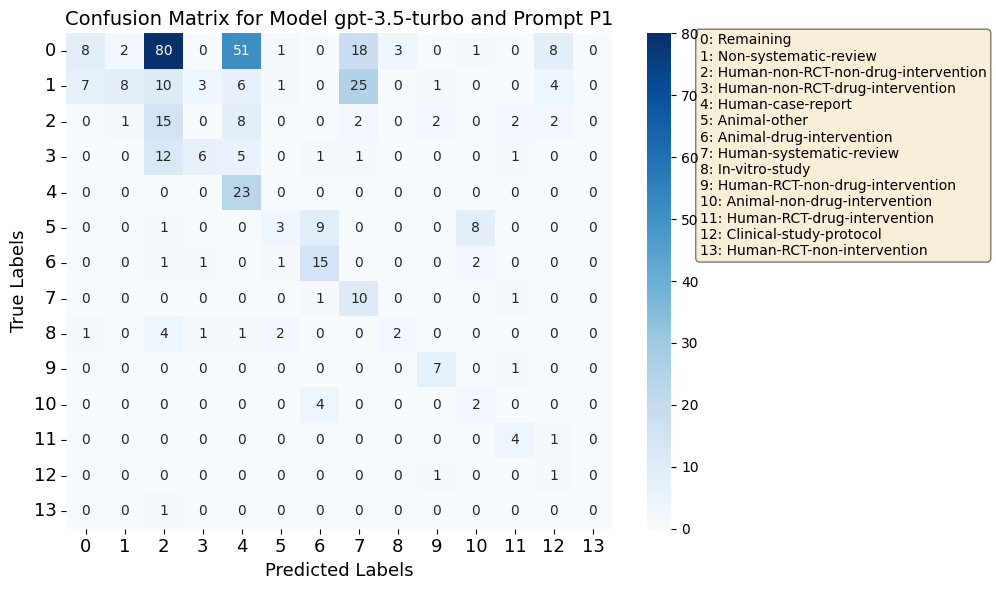

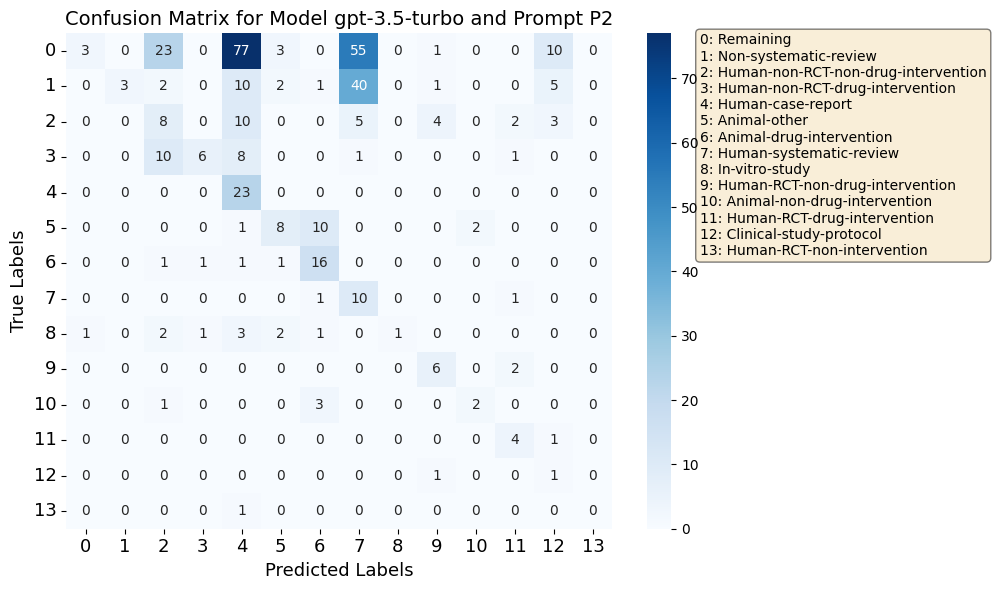

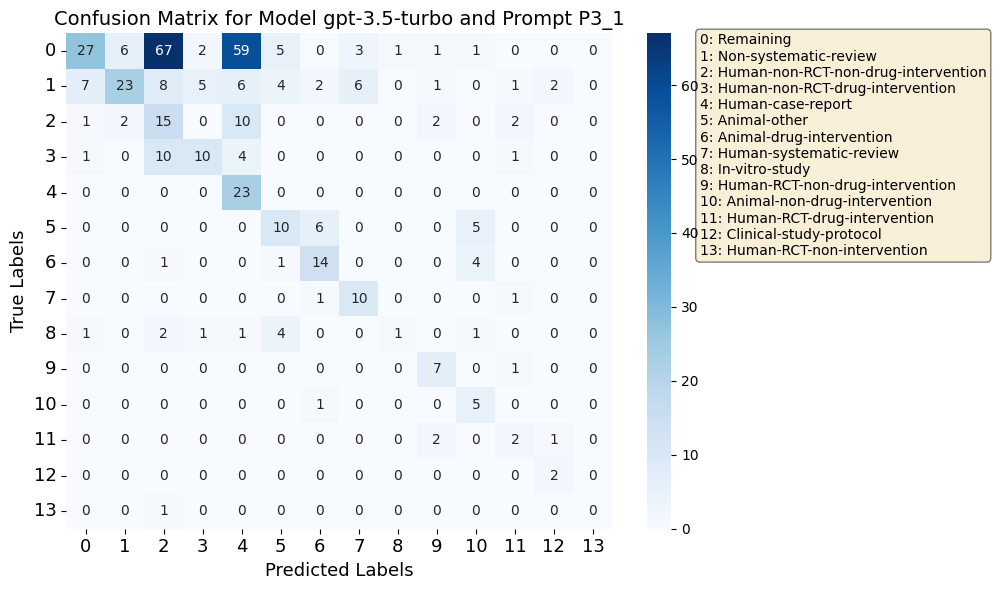

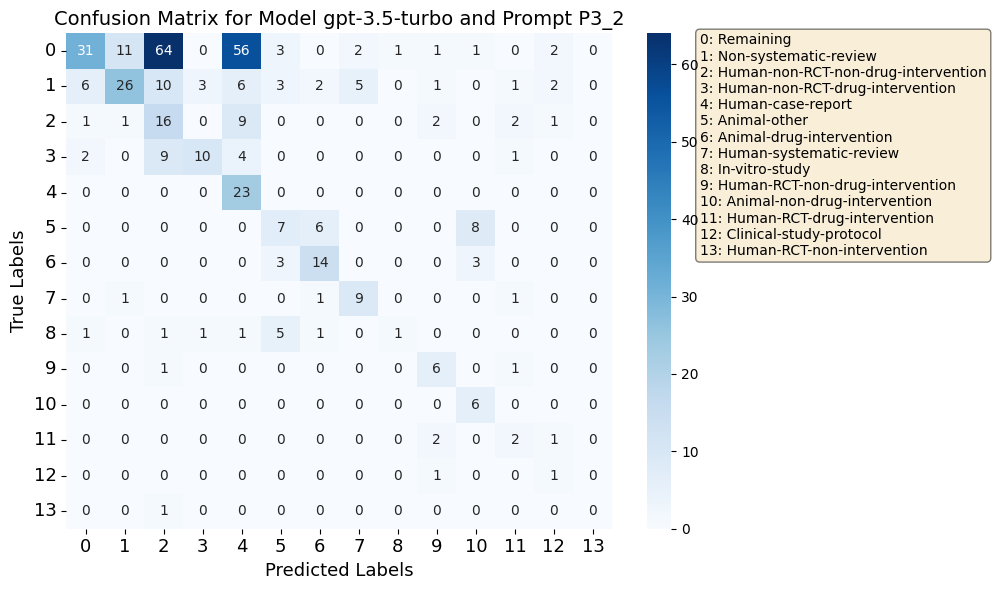

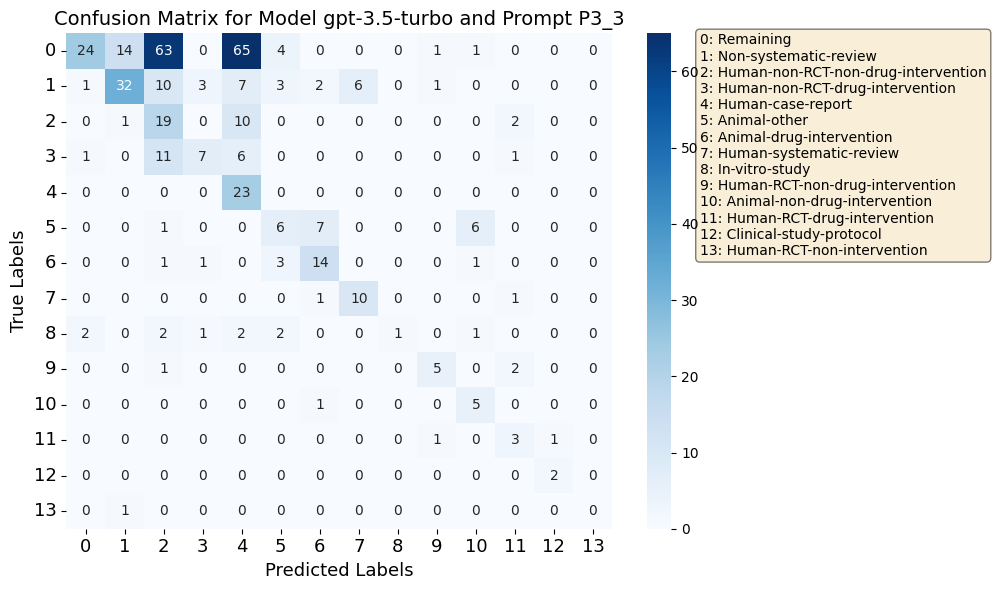

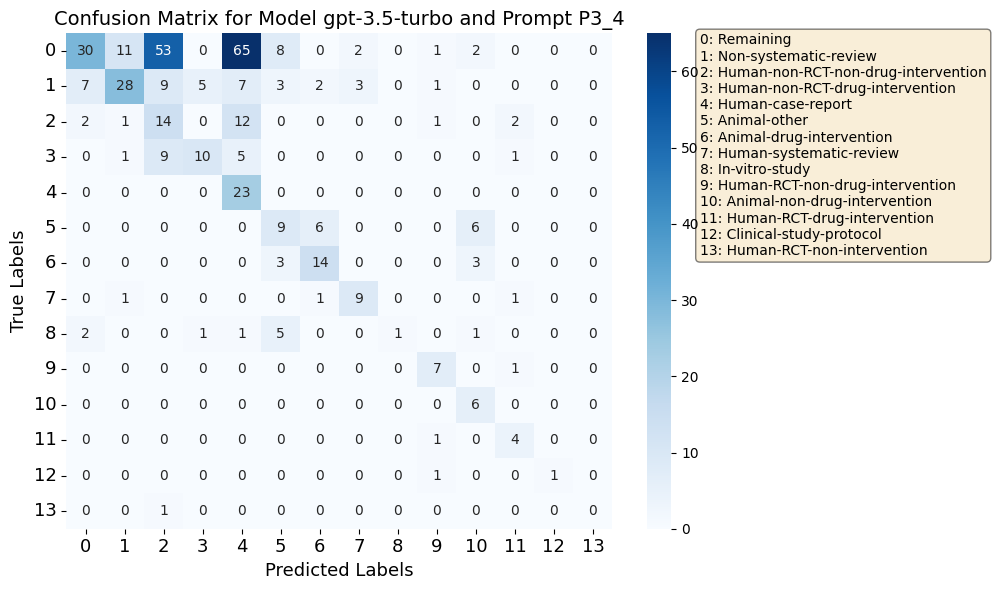

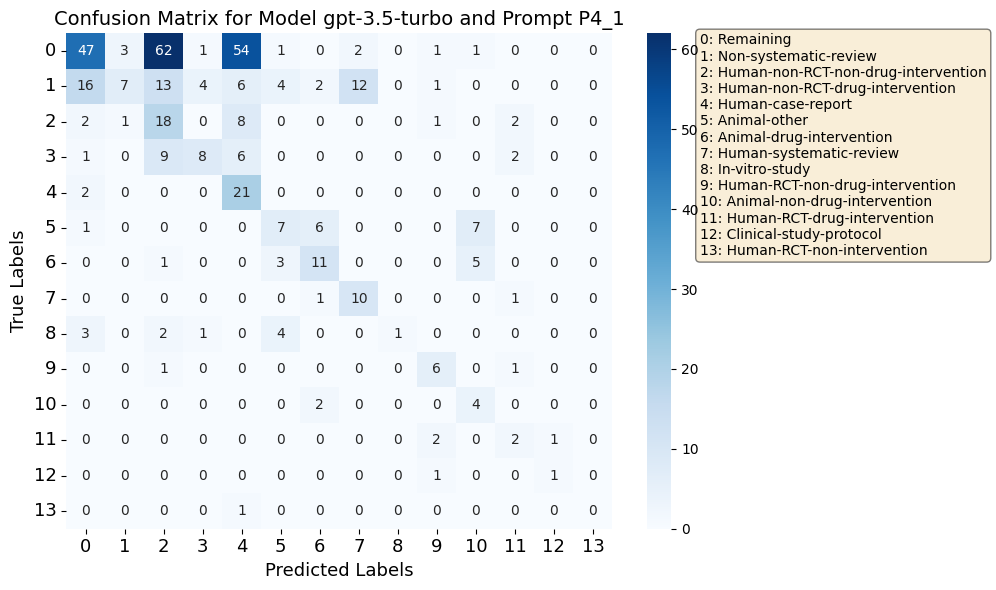

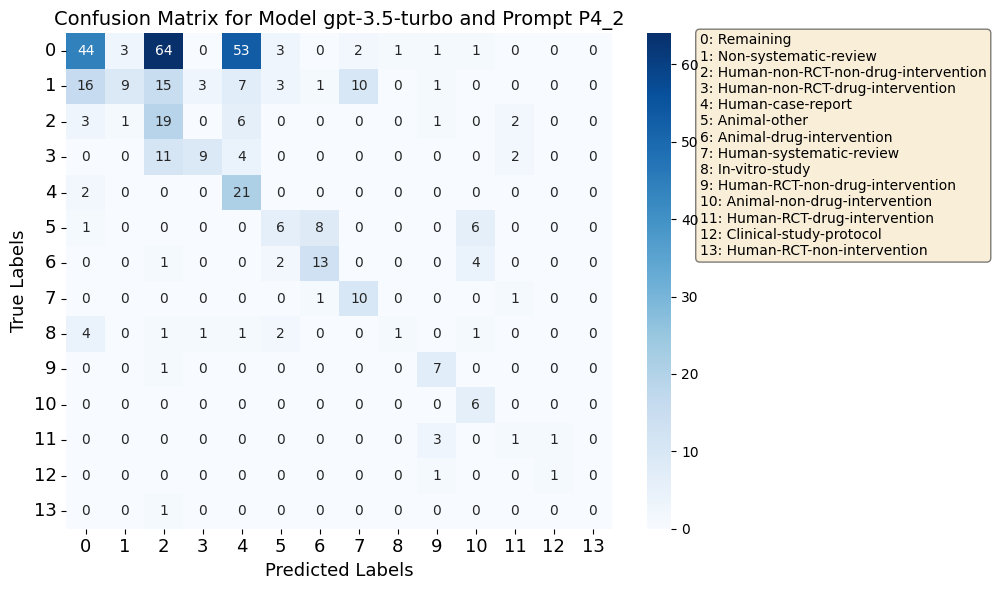

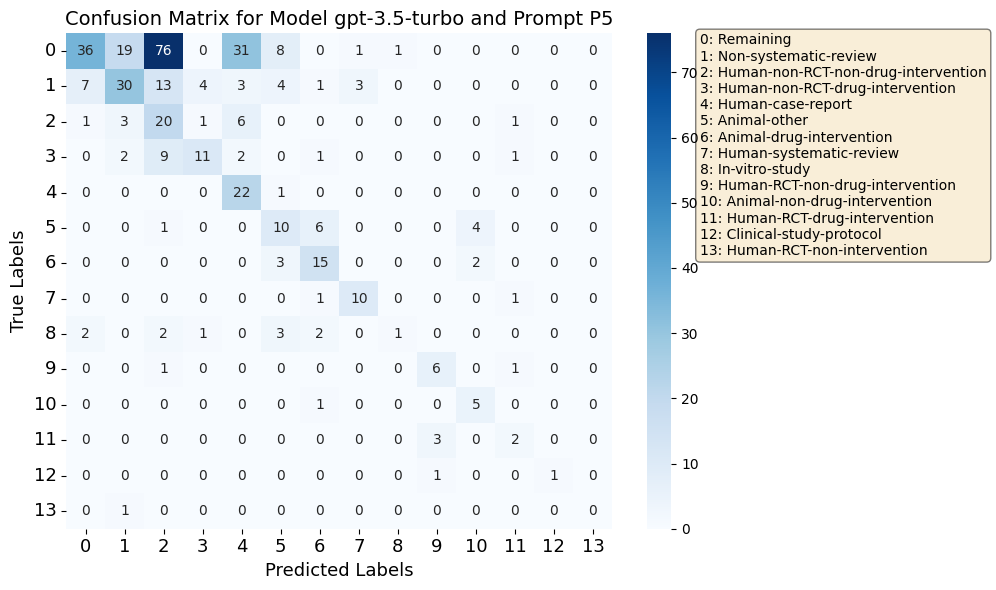

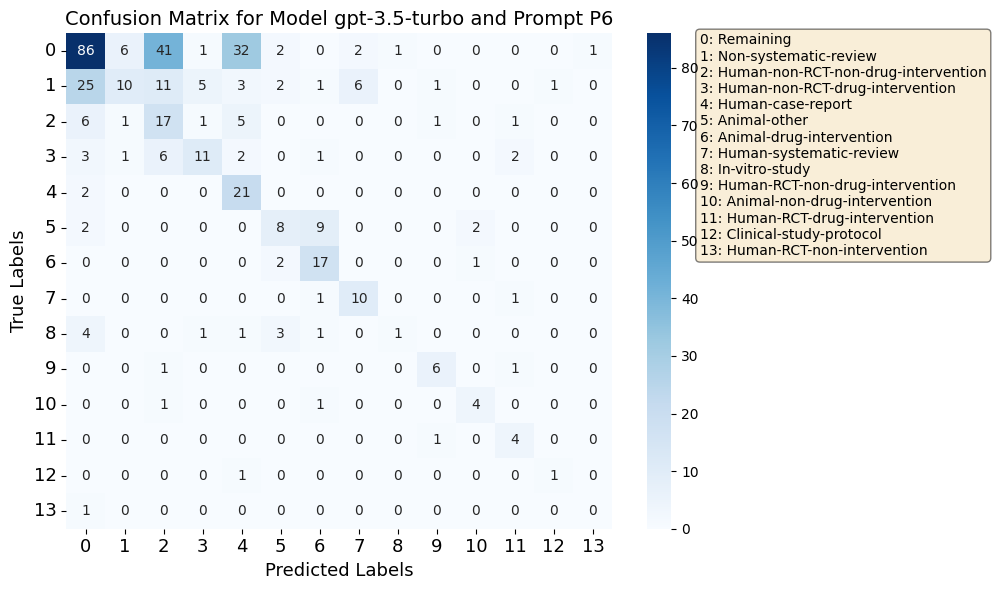

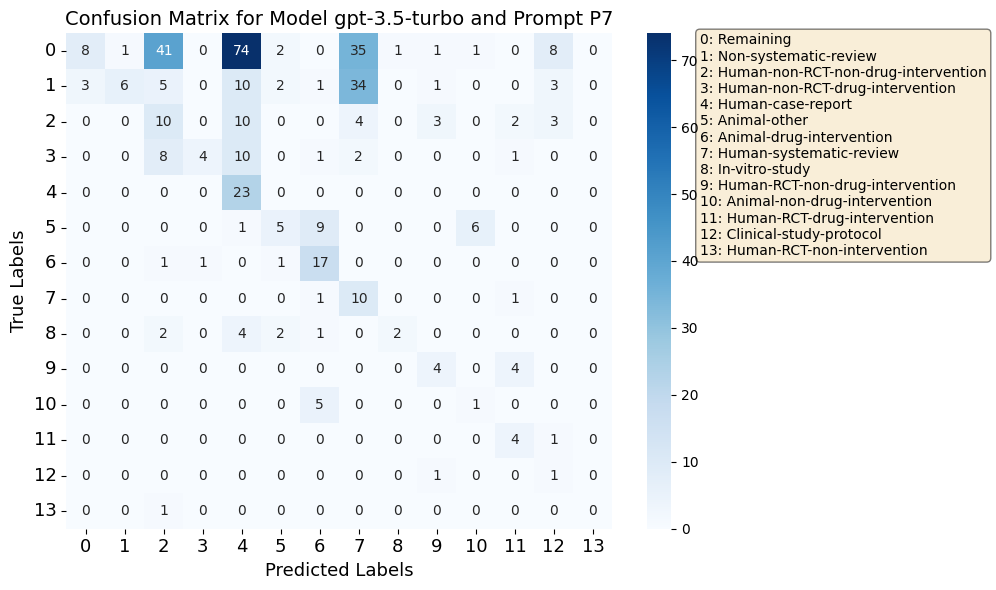

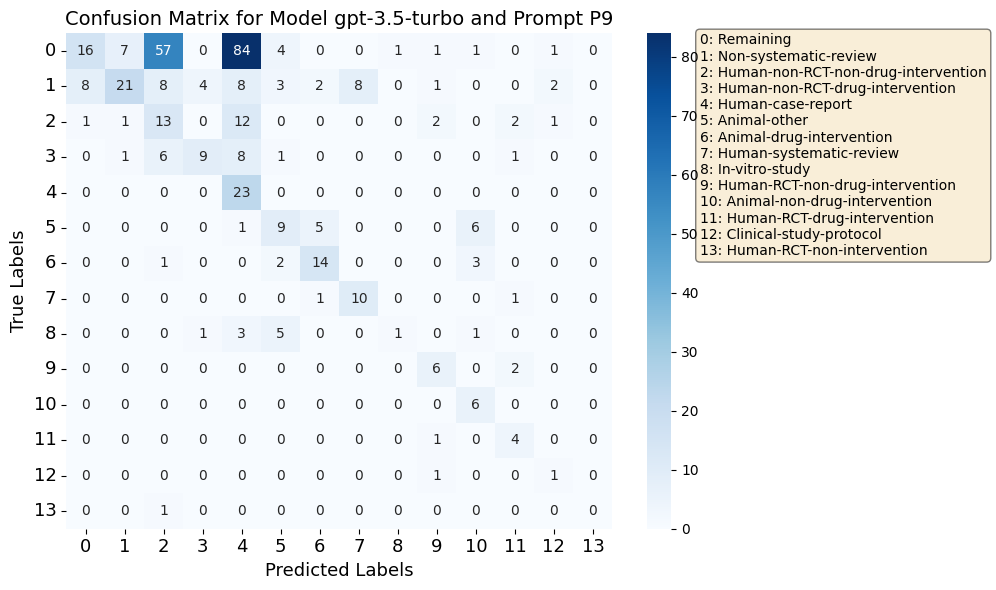

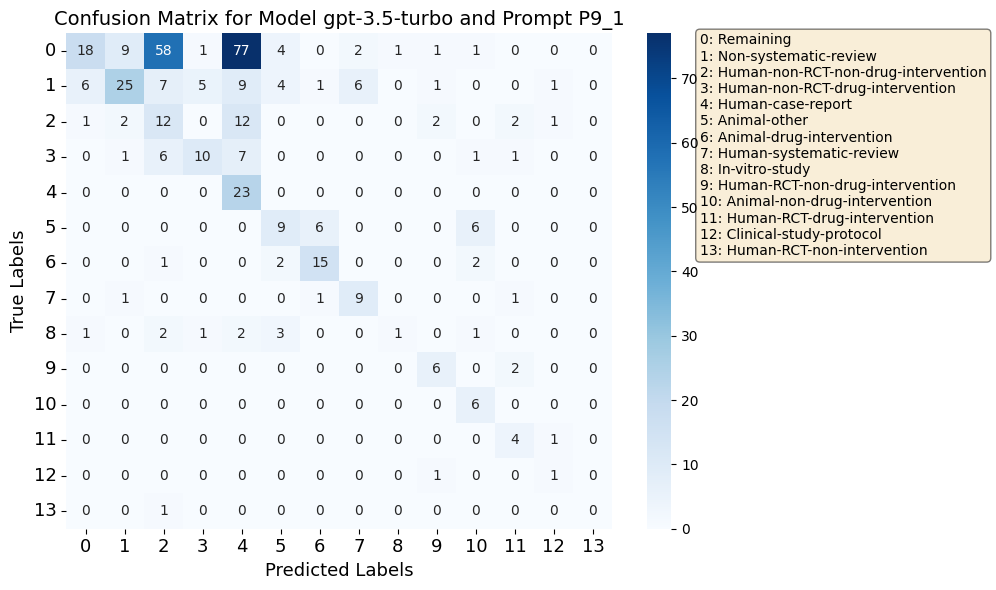

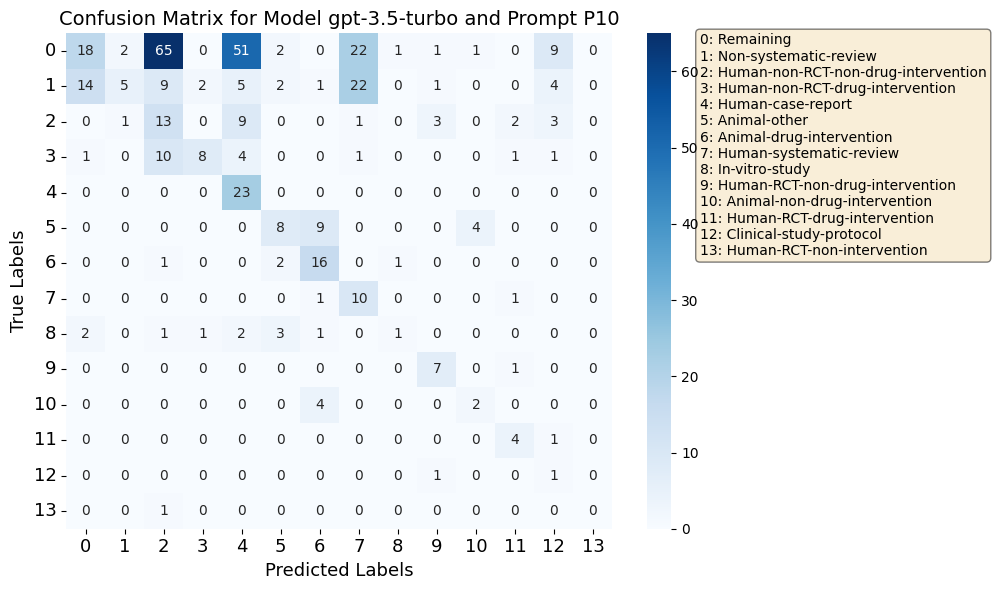

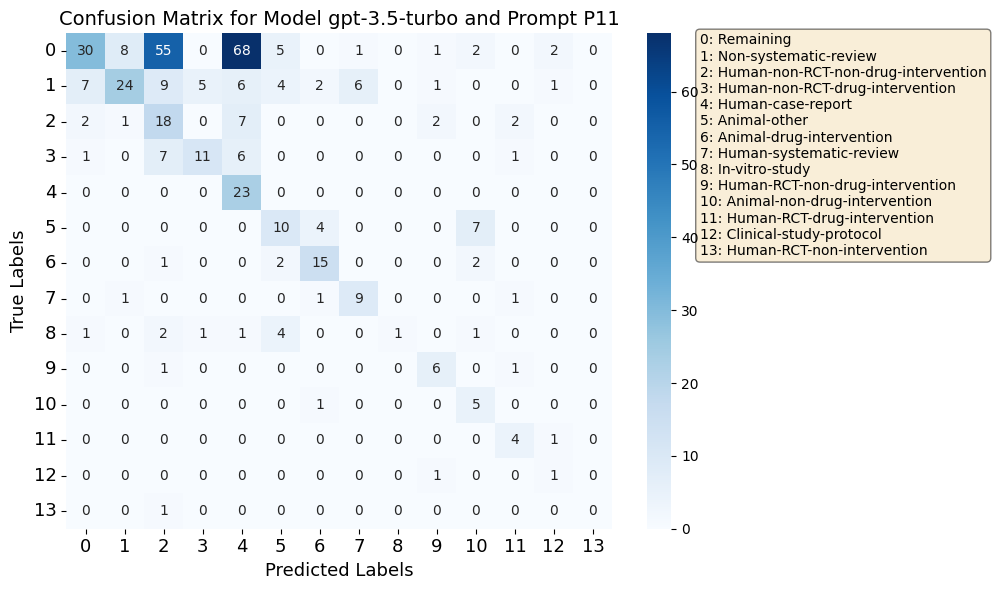

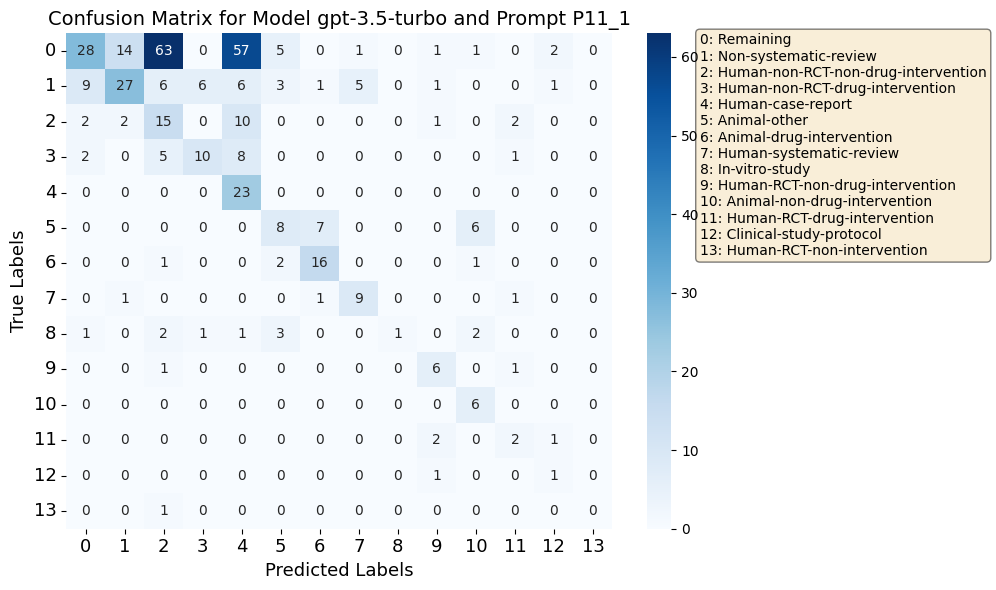

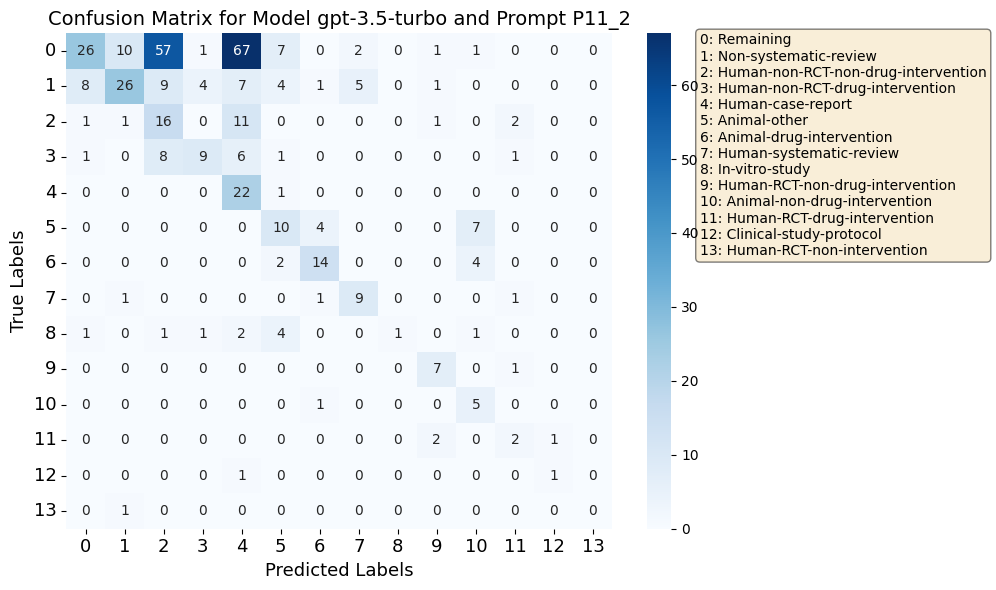

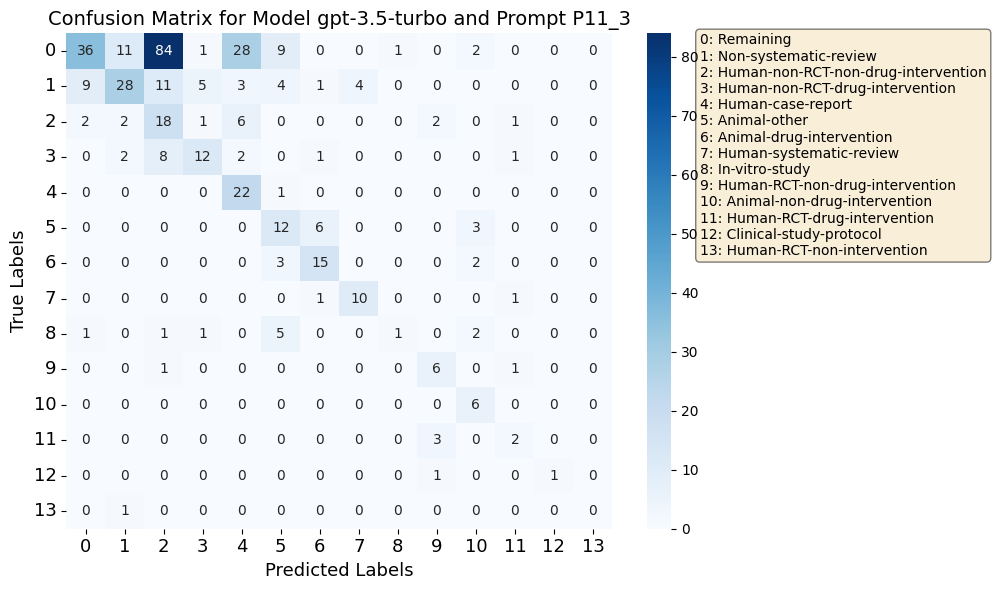

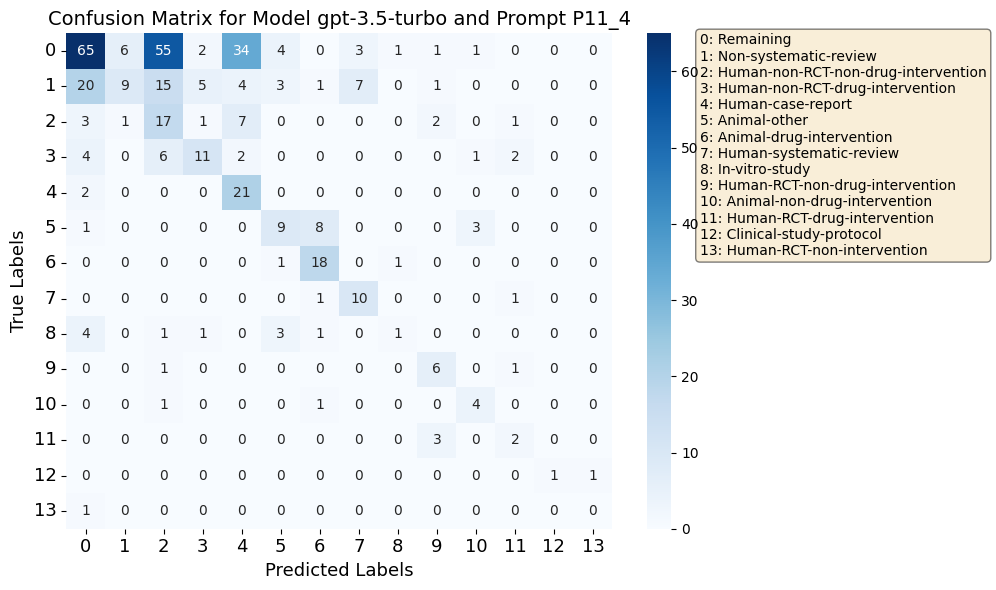

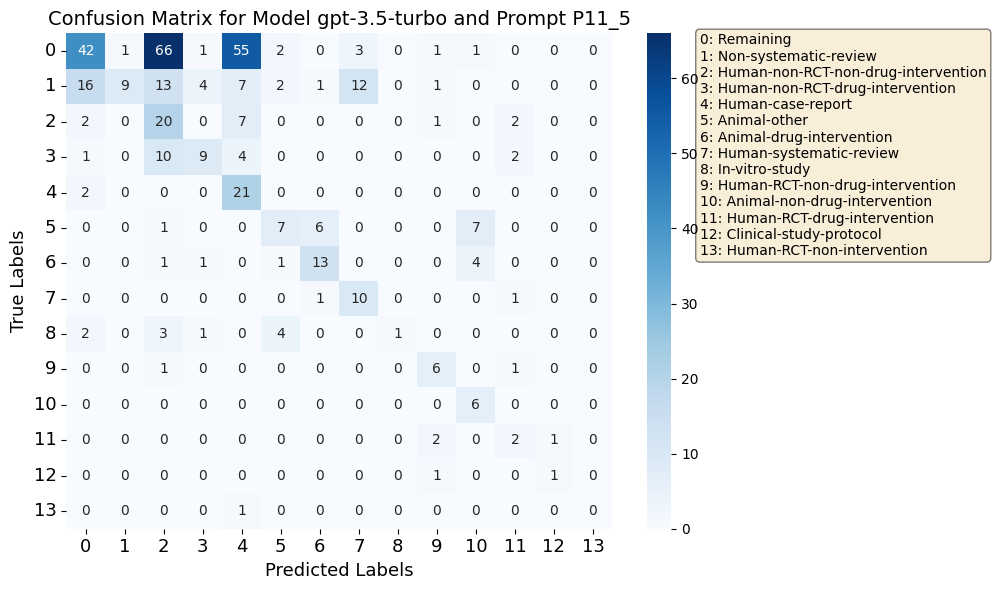

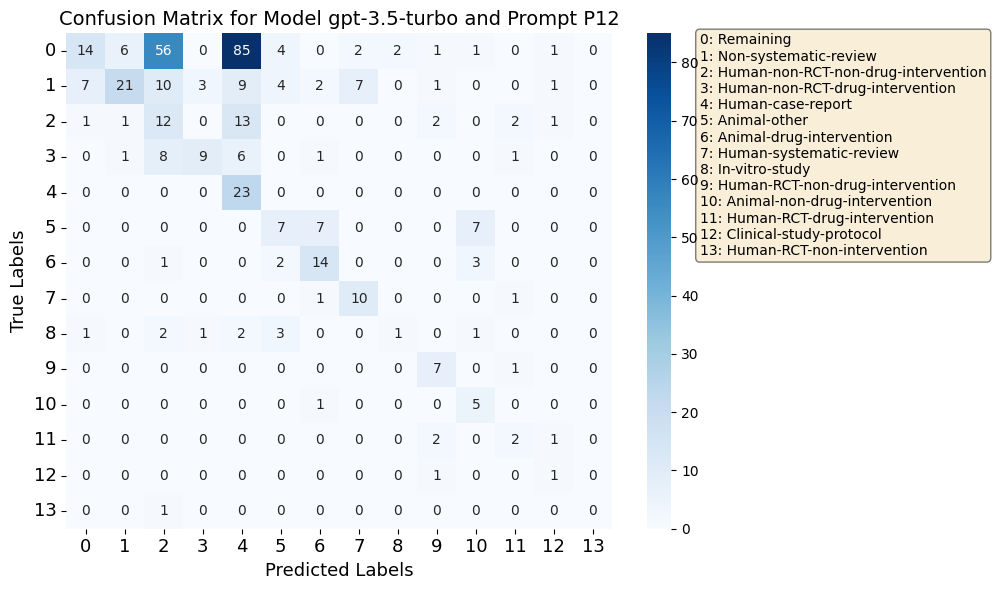

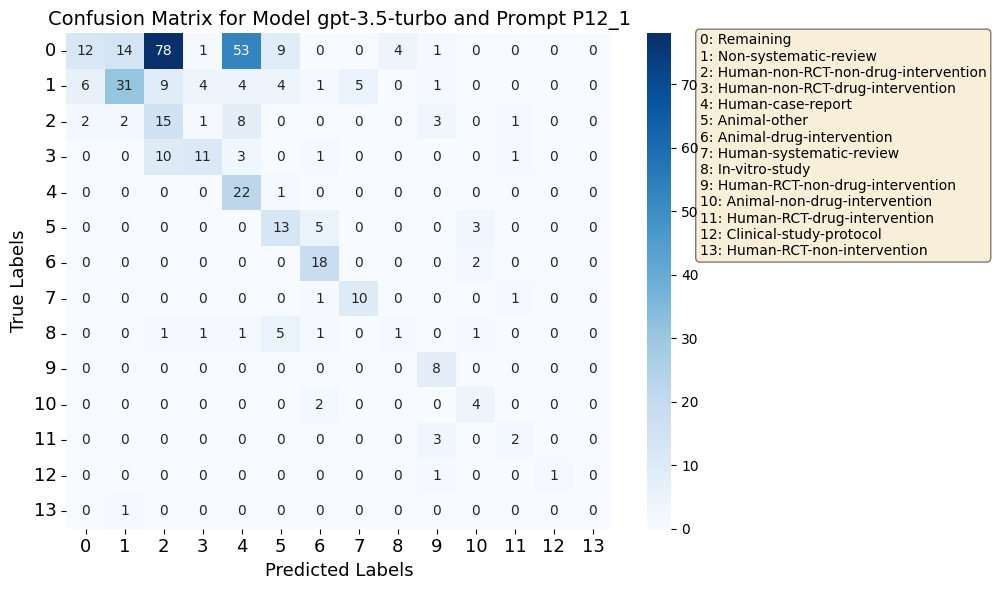

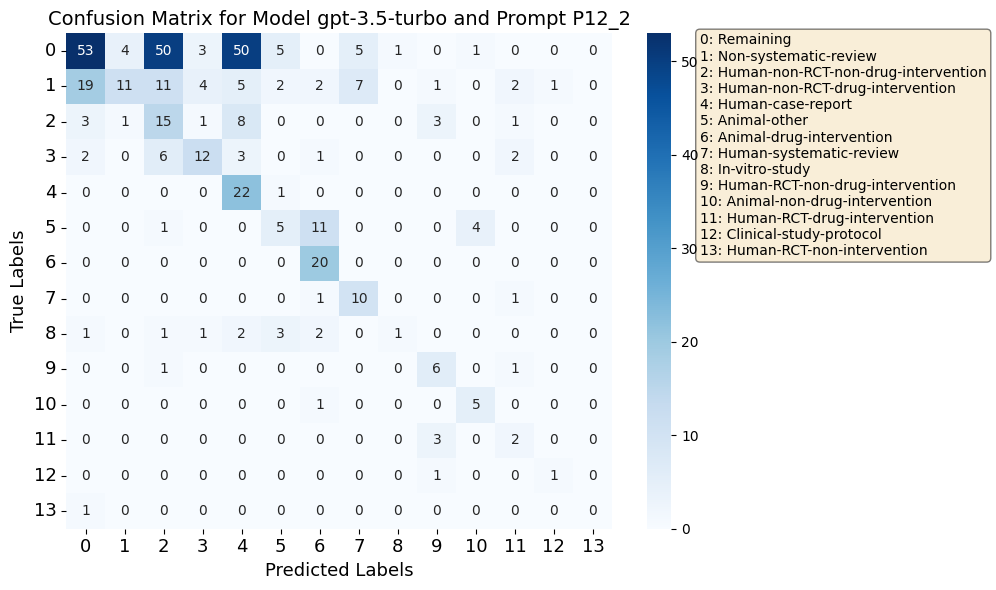

In [17]:
target_label_col = 'accepted_label_numerical'
eval_type = 'multi_label'
all_reports_df, summary_df = evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, csv_file_suffix="all_prompts")

In [18]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.471,"(0.341, 0.583)",0.257,"(0.218, 0.302)",0.210,"(0.168, 0.257)",0.257,"(0.215, 0.302)",P1
1,0.656,"(0.312, 0.783)",0.225,"(0.188, 0.267)",0.171,"(0.133, 0.215)",0.225,"(0.183, 0.267)",P2
2,0.592,"(0.504, 0.657)",0.369,"(0.324, 0.416)",0.359,"(0.308, 0.409)",0.369,"(0.324, 0.416)",P3_1
3,0.597,"(0.511, 0.658)",0.376,"(0.329, 0.426)",0.373,"(0.321, 0.424)",0.376,"(0.329, 0.423)",P3_2
4,0.653,"(0.565, 0.712)",0.374,"(0.329, 0.421)",0.359,"(0.308, 0.41)",0.374,"(0.327, 0.423)",P3_3
5,0.605,"(0.526, 0.67)",0.386,"(0.342, 0.436)",0.381,"(0.33, 0.433)",0.386,"(0.339, 0.433)",P3_4
6,0.547,"(0.466, 0.617)",0.354,"(0.307, 0.401)",0.349,"(0.297, 0.399)",0.354,"(0.309, 0.401)",P4_1
7,0.545,"(0.456, 0.608)",0.364,"(0.317, 0.412)",0.356,"(0.307, 0.408)",0.364,"(0.317, 0.411)",P4_2
8,0.605,"(0.522, 0.662)",0.418,"(0.371, 0.468)",0.413,"(0.359, 0.463)",0.418,"(0.371, 0.468)",P5
9,0.558,"(0.483, 0.61)",0.485,"(0.436, 0.535)",0.477,"(0.424, 0.527)",0.485,"(0.438, 0.535)",P6


In [19]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support,Prompt ID
class,,,,,,,,,,
Remaining,0.500,0.047,0.085,0.574,"(0.28, 0.72)","(0.024, 0.089)","(0.022, 0.148)","(0.526, 0.622)",172,P1
Non-systematic-review,0.727,0.123,0.211,0.851,"(0.434, 0.903)","(0.064, 0.225)","(0.083, 0.338)","(0.814, 0.883)",65,P1
Human-non-RCT-non-drug-intervention,0.121,0.469,0.192,0.688,"(0.075, 0.19)","(0.309, 0.636)","(0.104, 0.281)","(0.641, 0.731)",32,P1
Human-non-RCT-drug-intervention,0.545,0.231,0.324,0.938,"(0.28, 0.787)","(0.11, 0.421)","(0.128, 0.521)","(0.91, 0.958)",26,P1
Human-case-report,0.245,1.000,0.393,0.824,"(0.169, 0.34)","(0.857, 1.0)","(0.279, 0.507)","(0.784, 0.858)",23,P1
...,...,...,...,...,...,...,...,...,...,...
Human-RCT-non-intervention,0.000,0.000,0.000,0.998,"(nan, nan)","(0.0, 0.793)","(0.0, 0.0)","(0.986, 1.0)",1,P12_2
micro,0.403,0.403,0.403,NaN,"(0.356, 0.451)","(0.356, 0.451)","(0.356, 0.451)",NaN,404,P12_2
macro,NaN,0.501,0.393,NaN,"(nan, nan)","(nan, nan)","(0.36, 0.427)",NaN,404,P12_2


### Format Results and Generate LateX

In [20]:
#model = "gpt-4-turbo-preview"

#prompt_ids_to_eval = ["P6", "P7", "P11_3", "P11_4"]
#summary_gpt4_raw_1 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P1", "P4_1", "P5"]
#summary_gpt4_raw_2 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P12_2"]
#summary_gpt4_raw_3 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#summary_gpt4_raw = pd.concat([summary_gpt4_raw_1,summary_gpt4_raw_2, summary_gpt4_raw_3]) 
#summary_gpt4_raw

In [21]:
# Case of combining separately evaluated prompt files

#model = "gpt-3.5-turbo"

#prompt_ids_to_eval = ["P5"]
#summary_gpt3_raw_1 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P6"]
#summary_gpt3_raw_2 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P1"]
#summary_gpt3_raw_3 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P7"]
#summary_gpt3_raw_4 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P3_3","P3_4","P4_1","P4_2"]
#summary_gpt3_raw_5 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P11","P11_1","P11_2","P11_3"]
#summary_gpt3_raw_6 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P12_2"]
#summary_gpt3_raw_7 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#prompt_ids_to_eval = ["P11_4","P11_5","P12"]
#summary_gpt3_raw_8 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

#summary_gpt3_raw = pd.concat([summary_gpt3_raw_1,summary_gpt3_raw_2, summary_gpt3_raw_3, summary_gpt3_raw_4, summary_gpt3_raw_5, summary_gpt3_raw_6, summary_gpt3_raw_7, summary_gpt3_raw_8]) 
#summary_gpt3_raw

In [22]:
# case when the prompt files were combined before the evaluation and the evaluation is already in a single file

model = "gpt-3.5-turbo"

csv_file_suffix="all_prompts"
summary_gpt3_raw = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_{csv_file_suffix}_with_ci.csv", index_col=0)
summary_gpt3_raw

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.471,"(0.341, 0.583)",0.257,"(0.218, 0.302)",0.210,"(0.168, 0.257)",0.257,"(0.215, 0.302)",P1
1,0.656,"(0.312, 0.783)",0.225,"(0.188, 0.267)",0.171,"(0.133, 0.215)",0.225,"(0.183, 0.267)",P2
2,0.592,"(0.504, 0.657)",0.369,"(0.324, 0.416)",0.359,"(0.308, 0.409)",0.369,"(0.324, 0.416)",P3_1
3,0.597,"(0.511, 0.658)",0.376,"(0.329, 0.426)",0.373,"(0.321, 0.424)",0.376,"(0.329, 0.423)",P3_2
4,0.653,"(0.565, 0.712)",0.374,"(0.329, 0.421)",0.359,"(0.308, 0.41)",0.374,"(0.327, 0.423)",P3_3
5,0.605,"(0.526, 0.67)",0.386,"(0.342, 0.436)",0.381,"(0.33, 0.433)",0.386,"(0.339, 0.433)",P3_4
6,0.547,"(0.466, 0.617)",0.354,"(0.307, 0.401)",0.349,"(0.297, 0.399)",0.354,"(0.309, 0.401)",P4_1
7,0.545,"(0.456, 0.608)",0.364,"(0.317, 0.412)",0.356,"(0.307, 0.408)",0.364,"(0.317, 0.411)",P4_2
8,0.605,"(0.522, 0.662)",0.418,"(0.371, 0.468)",0.413,"(0.359, 0.463)",0.418,"(0.371, 0.468)",P5
9,0.558,"(0.483, 0.61)",0.485,"(0.436, 0.535)",0.477,"(0.424, 0.527)",0.485,"(0.438, 0.535)",P6


In [23]:
map_prompt_to_concept = {
    'P1': 'zero-shot',
    'P2': 'zero-shot',
    'P3_1': 'CC',
    'P3_2': 'CC',
    'P4_1': 'CC',
    'P4_2': 'CC',
    'P5': 'CC',
    'P6': 'CC',
    'P7': 'CoT',
    'P9': 'CoT + CC',
    'P9_1': 'CoT + CC',
    'P10': 'CoT',
    'P11': 'CoT + CC',
    'P11_1': 'CoT + CC',
    'P11_2': 'CoT + CC',
    'P11_3': 'CoT + CC',
    'P11_4': 'CoT + CC',
    'P11_5': 'CoT + CC',
    'P12': '2 CoT + CC',
    'P12_1': '2 CoT + CC',
    'P12_2': '2 CoT + CC'
}

In [24]:
# Custom sorting function
def custom_sort(prompt):
    import re
    # Extract numbers from the prompt
    numbers = re.findall(r'\d+', prompt)
    if numbers:
        # Primary sort by the first number, secondary sort by the full string
        return (int(numbers[0]), prompt)
    return (float('inf'), prompt)  # Handles cases without numbers
    
def format_summary_for_latex_report(summary_df, map_prompt_to_concept):
    summary_df = summary_df.copy()
    
    # Concatenating each metric with its CI
    summary_df['Precision (CI)'] = summary_df['precision'].astype(str) + ' ' + summary_df['precision CI'].astype(str)
    summary_df['Recall (CI)'] = summary_df['recall'].astype(str) + ' ' + summary_df['recall CI'].astype(str)
    summary_df['F1-Score (CI)'] = summary_df['f1-score'].astype(str) + ' ' + summary_df['f1-score CI'].astype(str)
    summary_df['Accuracy (CI)'] = summary_df['accuracy'].astype(str) + ' ' + summary_df['accuracy CI'].astype(str)
    
    # Dropping old columns
    summary_df.drop(columns=['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI'], inplace=True)
    
    # Rename 'Prompt ID' to 'Prompt'
    summary_df.rename(columns={'Prompt ID': 'Prompt'}, inplace=True)
    
    # Apply the mapping
    summary_df['Concept'] = summary_df['Prompt'].map(map_prompt_to_concept)
    
    # Rearrange the columns to put 'Concept' after 'Prompt'
    summary_df = summary_df[['Prompt', 'Concept', 'Precision (CI)', 'Recall (CI)', 'F1-Score (CI)', 'Accuracy (CI)']]

    summary_df['sort_key'] = summary_df['Prompt'].apply(custom_sort)
    summary_df.sort_values('sort_key', inplace=True)
    summary_df.drop('sort_key', inplace=True, axis=1)
    
    return summary_df
    

In [25]:
#summary_gpt4 = format_summary_for_latex_report(summary_gpt4_raw, map_prompt_to_concept)
#summary_gpt4['Model'] = 'gpt-4'
#summary_gpt4

In [26]:
#print(summary_gpt4.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

In [27]:
summary_gpt3 = format_summary_for_latex_report(summary_gpt3_raw, map_prompt_to_concept)
summary_gpt3['Model'] = 'gpt-3.5'
summary_gpt3 = summary_gpt3.dropna(subset=['Concept'])
summary_gpt3

,Prompt,Concept,Precision (CI),Recall (CI),F1-Score (CI),Accuracy (CI),Model
0,P1,zero-shot,"0.471 (0.341, 0.583)","0.257 (0.218, 0.302)","0.21 (0.168, 0.257)","0.257 (0.215, 0.302)",gpt-3.5
1,P2,zero-shot,"0.656 (0.312, 0.783)","0.225 (0.188, 0.267)","0.171 (0.133, 0.215)","0.225 (0.183, 0.267)",gpt-3.5
2,P3_1,CC,"0.592 (0.504, 0.657)","0.369 (0.324, 0.416)","0.359 (0.308, 0.409)","0.369 (0.324, 0.416)",gpt-3.5
3,P3_2,CC,"0.597 (0.511, 0.658)","0.376 (0.329, 0.426)","0.373 (0.321, 0.424)","0.376 (0.329, 0.423)",gpt-3.5
6,P4_1,CC,"0.547 (0.466, 0.617)","0.354 (0.307, 0.401)","0.349 (0.297, 0.399)","0.354 (0.309, 0.401)",gpt-3.5
7,P4_2,CC,"0.545 (0.456, 0.608)","0.364 (0.317, 0.412)","0.356 (0.307, 0.408)","0.364 (0.317, 0.411)",gpt-3.5
8,P5,CC,"0.605 (0.522, 0.662)","0.418 (0.371, 0.468)","0.413 (0.359, 0.463)","0.418 (0.371, 0.468)",gpt-3.5
9,P6,CC,"0.558 (0.483, 0.61)","0.485 (0.436, 0.535)","0.477 (0.424, 0.527)","0.485 (0.438, 0.535)",gpt-3.5
10,P7,CoT,"0.604 (0.432, 0.71)","0.235 (0.196, 0.28)","0.191 (0.149, 0.236)","0.235 (0.196, 0.277)",gpt-3.5
11,P9,CoT + CC,"0.551 (0.446, 0.633)","0.329 (0.285, 0.376)","0.308 (0.26, 0.36)","0.329 (0.285, 0.376)",gpt-3.5


In [28]:
summary_gpt3.drop(columns=['Model', 'Accuracy (CI)'], inplace=True)

print(summary_gpt3.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

\begin{tabular}{lllll}
\toprule
Prompt & Concept & Precision (CI) & Recall (CI) & F1-Score (CI) \\
\midrule
P1 & zero-shot & 0.471 (0.341, 0.583) & 0.257 (0.218, 0.302) & 0.21 (0.168, 0.257) \\
P2 & zero-shot & 0.656 (0.312, 0.783) & 0.225 (0.188, 0.267) & 0.171 (0.133, 0.215) \\
P3\_1 & CC & 0.592 (0.504, 0.657) & 0.369 (0.324, 0.416) & 0.359 (0.308, 0.409) \\
P3\_2 & CC & 0.597 (0.511, 0.658) & 0.376 (0.329, 0.426) & 0.373 (0.321, 0.424) \\
P4\_1 & CC & 0.547 (0.466, 0.617) & 0.354 (0.307, 0.401) & 0.349 (0.297, 0.399) \\
P4\_2 & CC & 0.545 (0.456, 0.608) & 0.364 (0.317, 0.412) & 0.356 (0.307, 0.408) \\
P5 & CC & 0.605 (0.522, 0.662) & 0.418 (0.371, 0.468) & 0.413 (0.359, 0.463) \\
P6 & CC & 0.558 (0.483, 0.61) & 0.485 (0.436, 0.535) & 0.477 (0.424, 0.527) \\
P7 & CoT & 0.604 (0.432, 0.71) & 0.235 (0.196, 0.28) & 0.191 (0.149, 0.236) \\
P9 & CoT + CC & 0.551 (0.446, 0.633) & 0.329 (0.285, 0.376) & 0.308 (0.26, 0.36) \\
P9\_1 & CoT + CC & 0.566 (0.458, 0.641) & 0.344 (0.3, 0.391) & 0.

### combine gpt-3.5 and gpt-4 results in one table

In [29]:
# Combine the DataFrames
#combined_df = pd.concat([summary_gpt4, summary_gpt3])

# Pivot table with multi-level columns for metrics and models as subcolumns
#pivot_df = combined_df.pivot_table(
    #index=['Prompt', 'Concept'],
    #columns='Model',
    #values=['Precision (CI)', 'Recall (CI)', 'F1-Score (CI)', 'Accuracy (CI)'],
    #aggfunc='first'
)

# Simplify the MultiIndex in columns
#pivot_df.columns = [' '.join(col).strip() for col in pivot_df.columns.values]
#pivot_df = pivot_df.reset_index()

#pivot_df['sort_key'] = pivot_df['Prompt'].apply(custom_sort)
#pivot_df.sort_values('sort_key', inplace=True)
#pivot_df.drop('sort_key', inplace=True, axis=1)

#pivot_df

SyntaxError: unmatched ')' (3215880725.py, line 10)

In [ ]:
#pivot_df = pd.DataFrame(pivot_df).drop(columns=['Accuracy (CI) gpt-3.5', 'Accuracy (CI) gpt-4'])

In [ ]:
# Creating MultiIndex for columns based on model and metric
#new_columns = [
    ##('Accuracy', 'gpt-3.5'), ('Accuracy', 'gpt-4'),
    #('Precision', 'gpt-3.5'), ('Precision', 'gpt-4'),
    #('Recall', 'gpt-3.5'), ('Recall', 'gpt-4'),
    #('F1-Score', 'gpt-3.5'), ('F1-Score', 'gpt-4')
]

# Define the new column index as a MultiIndex
#multi_index = pd.MultiIndex.from_tuples(new_columns, names=['Metric', 'Model'])

# Create a new DataFrame using only the relevant columns and assign the MultiIndex
#new_df = pd.DataFrame(pivot_df, columns=['Prompt', 'Concept', 
                                   ##'Accuracy (CI) gpt-3.5', 'Accuracy (CI) gpt-4',
                                   #'Precision (CI) gpt-3.5', 'Precision (CI) gpt-4',
                                   #'Recall (CI) gpt-3.5', 'Recall (CI) gpt-4',
                                   #'F1-Score (CI) gpt-3.5', 'F1-Score (CI) gpt-4',])

# Rename columns to match the MultiIndex
#new_df.columns = ['Prompt', 'Concept'] + multi_index.to_flat_index().tolist()

# Set the new column index
#new_df.columns = pd.MultiIndex.from_tuples([('', 'Prompt'), ('', 'Concept')] + new_columns)

#new_df

In [ ]:
# Formatter function to convert float to percentage
#def to_percentage(x):
    #return "{:.1f}%".format(x * 100)

# Define column formatters
#formatters = {
    #'Prompt': lambda x: x.replace('_', r'\_'),
    #'Accuracy (gpt-3.5)': to_percentage,
    #'Accuracy (gpt-4)': to_percentage,
    #'F1-Score (gpt-3.5)': to_percentage,
    #'F1-Score (gpt-4)': to_percentage,
    #'Precision (gpt-3.5)': to_percentage,
    #'Precision (gpt-4)': to_percentage,
    #'Recall (gpt-3.5)': to_percentage,
    #'Recall (gpt-4)': to_percentage,
}

In [ ]:
#print(new_df.to_latex(float_format="%.3f", index=False, formatters={'': lambda x: x.replace('_', r'\_')}))